In [1]:
#mount google drive when on google colab and set working directory

import sys
import os

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/music_speech/')

working_dir = os.getcwd()
print(f'\nWorking directory: {working_dir}')


Working directory: /Users/kraehenb/music_speech


In [2]:
#check working directory and repo (git clone git@github.com:jkcas22/music_speech.git)

!{sys.executable} -m pip install gitpython
import git

repo = ['git@github.com:jkcas22/music_speech.git', 'https://github.com/jkcas22/music_speech.git']

if git.Repo(working_dir).remotes.origin.url in repo:
    print(f'\nRepository and working directory are fine.')
else:
    print(f'\nRepository: {git.Repo(working_dir).remotes.origin.url}')


Repository and working directory are fine.


In [3]:
#initialize environment, load modules/libraries

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

#import python code from seperate files
from helpers.fourier_transform import load_wav, dft_logmag, patches

2023-03-01 18:26:56.592437: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
music_dir = './data/music_wav'
if not os.path.isdir(music_dir): 
    print(f'copy folder "music_wav" from unzipped 34.tar to {os.path.join(working_dir, "data","")}')

music_test = [
    'unpoco.wav',
    'blues.wav',
    'gismonti.wav',
    'ipanema.wav',
    'deedee.wav',
    'hendrix.wav',
    'madradeus.wav',
    'marlene.wav',
    'beatles.wav',
    'bagpipe.wav',
    'redhot.wav',
    'jazz.wav'
]
music_test = [os.path.join(music_dir, file) for file in music_test]

music = [os.path.join(music_dir, file) for file in os.listdir(music_dir) if file.endswith('.wav')]
music = list(set(music)-set(music_test))

speech_dir = './data/speech_wav'
if not os.path.isdir(speech_dir): 
    print(f'copy folder "speech_wav" from unzipped 34.tar to {os.path.join(working_dir, "data","")}')

speech_test = [
    'comedy.wav',
    'thlui.wav',
    'voices.wav',
    'conversion.wav',
    'china.wav',
    'vegetables2.wav',
    'amal.wav',
    'teachers2.wav',
    'chant.wav',
    'pulp2.wav',
    'acomic.wav',
    'kid.wav'
]
speech_test = [os.path.join(speech_dir, file) for file in speech_test]

speech = [os.path.join(speech_dir, file) for file in os.listdir(speech_dir) if file.endswith('.wav')]
speech = list(set(speech)-set(speech_test))

In [5]:
test = speech_test + music_test
test_labels = np.zeros(len(test))
test_labels[0:len(speech_test)]=1

split = len(speech)*8//10

train = speech[:split] + music[:split]
train_labels = np.zeros(len(train))
train_labels[:split]=1

validate = speech[split:] + music[split:]
validate_labels = np.zeros(len(validate))
validate_labels[:len(speech[split:])]=1

def permute(data, labels):
    p = list(zip(data,labels))
    random.shuffle(p)
    data, labels = zip(*p)
    return data, labels

test, test_labels = permute(test, test_labels)
train, train_labels = permute(train, train_labels)
validate, validate_labels = permute(validate, validate_labels)

print("Number of sounds (music and speech)")
print(f"- Test: {len(test)}")
print(f"- Validation: {len(validate)}")
print(f"- Training: {len(train)}")

Number of sounds (music and speech)
- Test: 24
- Validation: 22
- Training: 82


In [6]:
test_sounds = load_wav(test)
train_sounds = load_wav(train)
validate_sounds = load_wav(validate)

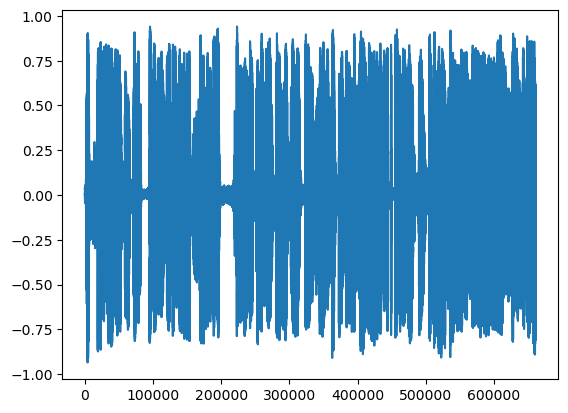

In [7]:
plt.plot(train_sounds[0])
plt.show()

In [8]:
fft_step=256
fft_size=512
fft_chunks = len(train_sounds[0])//fft_step

test_logmag = dft_logmag(test_sounds,fft_chunks,fft_step,fft_size)
train_logmag = dft_logmag(train_sounds,fft_chunks,fft_step,fft_size)
validate_logmag = dft_logmag(validate_sounds,fft_chunks,fft_step,fft_size)

print("logmag shape")
print(f"- Test: {test_logmag.shape}")
print(f"- Validation: {validate_logmag.shape}")
print(f"- Training: {train_logmag.shape}")

logmag shape
- Test: (24, 2583, 256)
- Validation: (22, 2583, 256)
- Training: (82, 2583, 256)


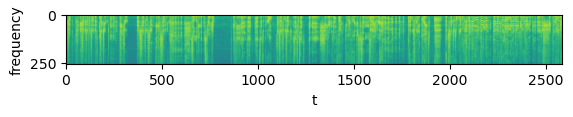

In [9]:
plt.imshow(train_logmag[0].T)
plt.xlabel('t')
plt.ylabel('frequency')
plt.show()

In [10]:
patch_step = 1
patch_size = 20

n_timesteps, n_feature = train_logmag[0].shape

part_split = 5
part_step = (n_timesteps-(patch_size-patch_step))//part_split
part_size = part_step + (patch_size-patch_step)

train_logmag_parts = patches(train_logmag,part_step,part_size)
validate_logmag_parts = patches(validate_logmag,part_step,part_size)
test_logmag_parts = patches(test_logmag,part_step,part_size)

_, _, n_timesteps, n_feature = train_logmag_parts.shape

train_logmag_parts = np.reshape(train_logmag_parts,(-1,n_timesteps, n_feature))
validate_logmag_parts = np.reshape(validate_logmag_parts,(-1,n_timesteps, n_feature))
test_logmag_parts = np.reshape(test_logmag_parts,(-1,n_timesteps, n_feature))

train_labels_parts = np.array([train_labels]*part_split).T.flatten()
validate_labels_parts = np.array([validate_labels]*part_split).T.flatten()
test_labels_parts = np.array([test_labels]*part_split).T.flatten()

print("logmag_parts shape")
print(f"- Test: {test_logmag_parts.shape}")
print(f"- Validation: {validate_logmag_parts.shape}")
print(f"- Training: {train_logmag_parts.shape}")

logmag_parts shape
- Test: (120, 531, 256)
- Validation: (110, 531, 256)
- Training: (410, 531, 256)


(410, 531, 256)


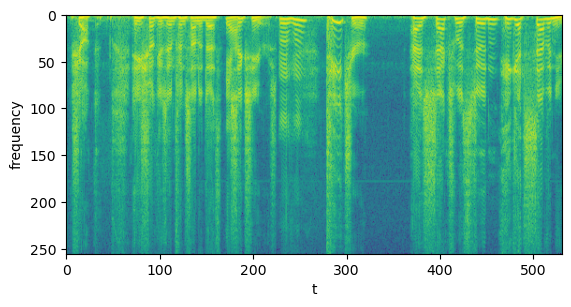

In [11]:
print(train_logmag_parts.shape)
plt.imshow(train_logmag_parts[0].T)
plt.xlabel('t')
plt.ylabel('frequency')
plt.show()

In [12]:
train_permute = list(range(len(train_labels_parts)))
validate_permute = list(range(len(validate_labels_parts)))
test_permute = list(range(len(test_labels_parts)))
random.shuffle(train_permute)
random.shuffle(validate_permute)
random.shuffle(test_permute)

train_labels_parts = train_labels_parts[train_permute]
validate_labels_parts = validate_labels_parts[validate_permute]
test_labels_parts = test_labels_parts[test_permute]

train_logmag_parts = train_logmag_parts[train_permute,:,:]
validate_logmag_parts = validate_logmag_parts[validate_permute,:,:]
test_logmag_parts = test_logmag_parts[test_permute,:,:]


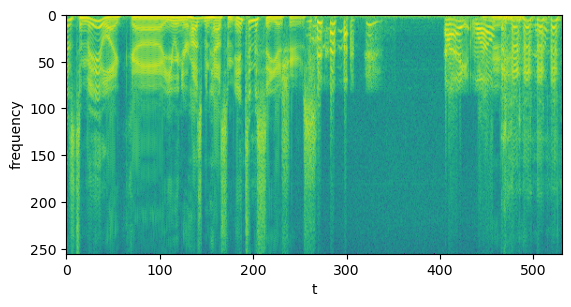

In [13]:
plt.imshow(train_logmag_parts[0].T)
plt.xlabel('t')
plt.ylabel('frequency')
plt.show()

In [14]:
def ds_window(sound, label):
    # labels = np.array(range(len(sound)))
    # sound = np.c_[sound,labels]
    if label > 0: 
        label = [0,1]
    else:
        label = [1,0] 
    labels = np.ones((n_timesteps,2))*label
    sound = np.c_[sound,labels]
    #ds = tf.expand_dims(sound, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(sound)
    ds = ds.window(size=patch_size,shift=patch_step,drop_remainder=True)
    return ds

def ds_patches(sounds, labels):
    ds = ds_window(sounds[0],labels[0])
    for sound, label in zip(sounds[1:],labels[1:]): ds = ds.concatenate(ds_window(sound,label))
    ds = ds.flat_map(lambda x: x.batch(patch_size))
    ds = ds.map(lambda x: (x[:,:-2], x[0,-2:]))
    return ds.batch(1)

test_ds = ds_patches(test_logmag_parts, test_labels_parts)
train_ds = ds_patches(train_logmag_parts, train_labels_parts)
validate_ds = ds_patches(validate_logmag_parts, validate_labels_parts)

n_chunks = ((test_logmag_parts.shape[1]-patch_size)//patch_step)+1
n_test = test_logmag_parts.shape[0]*n_chunks
n_train = train_logmag_parts.shape[0]*n_chunks
n_validate = validate_logmag_parts.shape[0]*n_chunks

print(f"{train_ds}\n")
print("Total number of chunks")
print(f"- Test: {n_test}")
print(f"- Validation: {n_validate}")
print(f"- Training: {n_train}")


2023-03-01 18:27:34.202977: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<BatchDataset element_spec=(TensorSpec(shape=(None, None, 256), dtype=tf.float64, name=None), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))>

Total number of chunks
- Test: 61440
- Validation: 56320
- Training: 209920


In [15]:
for sound, label in train_ds.take(1):
    print(sound.numpy().shape)
    print(label.numpy().shape)

(1, 20, 256)
(1, 2)


In [16]:
n = 10
for sound, label in train_ds.take(n):
    sound = sound.numpy()[0]
    print(f"{sound.shape} : {sound[[0,patch_step],0]} : {sound[[-patch_step-1,-1],0]}")

(20, 256) : [-5.30198902 -5.82262477] : [-3.91787662 -4.17436976]
(20, 256) : [-5.82262477 -5.91020882] : [-4.17436976 -6.12150315]
(20, 256) : [-5.91020882 -5.89094797] : [-6.12150315 -5.94383543]
(20, 256) : [-5.89094797 -5.52514374] : [-5.94383543 -4.69359366]
(20, 256) : [-5.52514374 -6.33110507] : [-4.69359366 -5.2049737 ]
(20, 256) : [-6.33110507 -5.08031363] : [-5.2049737  -6.03180536]
(20, 256) : [-5.08031363 -5.95640559] : [-6.03180536 -4.1909057 ]
(20, 256) : [-5.95640559 -5.07233989] : [-4.1909057  -4.82164205]
(20, 256) : [-5.07233989 -5.06410014] : [-4.82164205 -4.79464488]
(20, 256) : [-5.06410014 -5.40407394] : [-4.79464488 -5.58283102]


Labels: [[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]


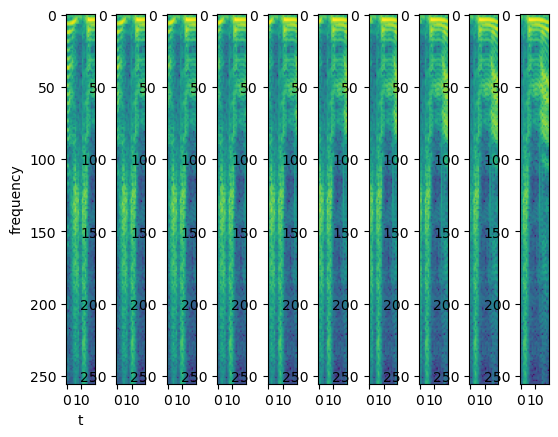

In [17]:
labels =[]
for i, (sound, label) in enumerate(train_ds.take(n)):
    labels+=[label[0].numpy().tolist()]
    plt.subplot(1,n,i+1)
    plt.imshow(sound.numpy()[0].T)
    if i == 0:
        plt.xlabel('t')
        plt.ylabel('frequency')
print(f"Labels: {labels}")
plt.show()

In [18]:
train_ds = train_ds.shuffle(10*n_chunks).prefetch(1)
validate_ds = validate_ds.shuffle(10*n_chunks).prefetch(1)
test_ds = test_ds.shuffle(10*n_chunks).prefetch(1)


Labels: [[0.0, 1.0], [1.0, 0.0], [1.0, 0.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [1.0, 0.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]


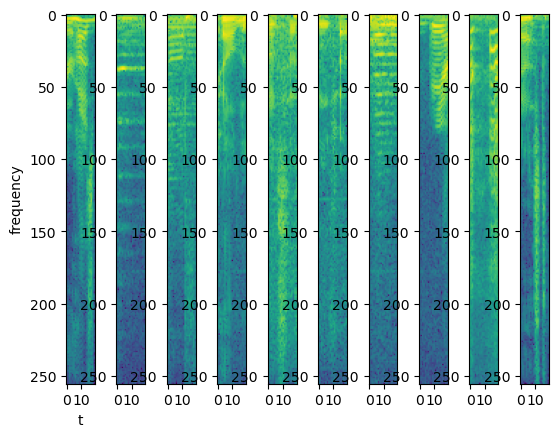

In [19]:
labels =[]
for i, (sound, label) in enumerate(train_ds.take(n)):
    labels+=[label[0].numpy().tolist()]
    plt.subplot(1,n,i+1)
    plt.imshow(sound.numpy()[0].T)
    if i == 0:
        plt.xlabel('t')
        plt.ylabel('frequency')
print(f"Labels: {labels}")
plt.show()


In [20]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256,return_sequences=False, input_shape=(patch_size,n_feature)))
# model.add(tf.keras.layers.LSTM(256,return_sequences=True)) 
# model.add(tf.keras.layers.LSTM(256,return_sequences=False))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 2)                 514       
                                                                 
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [21]:
hist = model.fit(train_ds, validation_data=validate_ds, batch_size=512, epochs=4, steps_per_epoch=1000, validation_steps=1000, verbose=1)

Epoch 1/4
1000/1000 [==============================] - 53s 42ms/step - loss: 0.8122 - accuracy: 0.5810 - val_loss: 0.7233 - val_accuracy: 0.2340
Epoch 2/4
1000/1000 [==============================] - 38s 38ms/step - loss: 0.7689 - accuracy: 0.5680 - val_loss: 0.6559 - val_accuracy: 0.7690
Epoch 3/4
1000/1000 [==============================] - 38s 38ms/step - loss: 0.7426 - accuracy: 0.5670 - val_loss: 0.9511 - val_accuracy: 0.2730
Epoch 4/4
1000/1000 [==============================] - 38s 38ms/step - loss: 0.7398 - accuracy: 0.5950 - val_loss: 0.5819 - val_accuracy: 0.7480


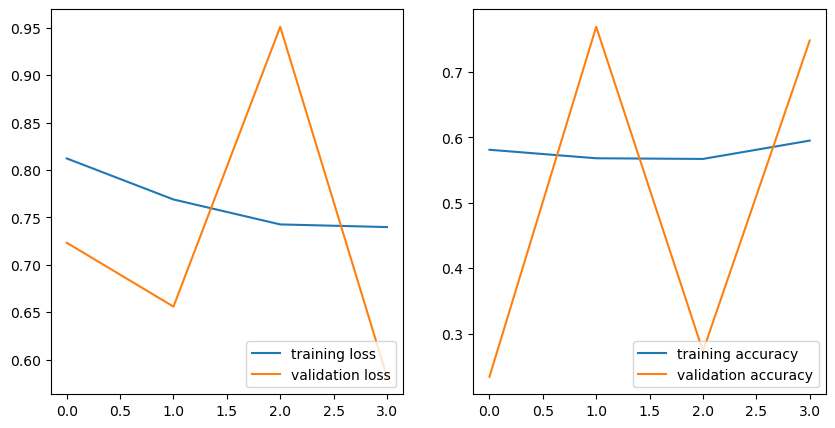

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='lower right')

axs[1].plot(hist.epoch, hist.history['accuracy'])
axs[1].plot(hist.epoch, hist.history['val_accuracy'])
axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')

plt.show()

In [23]:
ds = test_ds.take(20)
labels = [e[1].numpy() for e in ds]
preds = [e for e in model.predict(ds)]

print("Label : Predicted")
for label, pred in zip(labels,preds):
    print(f"{label[0]} {pred}")

20/20 [==============================] - 4s 48ms/step
Label : Predicted
[1. 0.] [0.17729923 0.82270074]
[1. 0.] [0.17729923 0.82270074]
[1. 0.] [0.17729923 0.82270074]
[0. 1.] [0.17729923 0.82270074]
[1. 0.] [0.17729923 0.82270074]
[0. 1.] [0.17729923 0.82270074]
[1. 0.] [0.17729923 0.82270074]
[0. 1.] [0.17729923 0.82270074]
[1. 0.] [0.17729923 0.82270074]
[0. 1.] [0.17729923 0.82270074]
[0. 1.] [0.17729923 0.82270074]
[1. 0.] [0.17729923 0.82270074]
[0. 1.] [0.17729923 0.82270074]
[0. 1.] [0.17729923 0.82270074]
[0. 1.] [0.17729923 0.82270074]
[1. 0.] [0.17729923 0.82270074]
[0. 1.] [0.17729923 0.82270074]
[0. 1.] [0.17729923 0.82270074]
[0. 1.] [0.17729923 0.82270074]
[0. 1.] [0.17729923 0.82270074]


In [24]:

model.evaluate(test_ds.take(1000))

1000/1000 [==============================] - 8s 5ms/step - loss: 0.8827 - accuracy: 0.5520


[0.8827397227287292, 0.5519999861717224]